Done so far for sentiment aspect:

- EDA to explore structure of text, categorisation, and sentiment
- Traditional baselines using vader and textblob
- Explore architectures in sklearn using tfidf
- Explore using word embeddings from pretrained models (improvement, and mlp does well)


This notebook: domain adaptation.

### Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is', device, '| gpu name:', torch.cuda.get_device_name())

Device is cuda | gpu name: NVIDIA GeForce RTX 4080 SUPER


### Load and split data (stratified)

Same test split as other notebooks

In [2]:
from spreadsheet_data_handling import tweak_for_sentiment
from sklearn.model_selection import train_test_split

#Could use tweak_generic for MLM/domain-adaptation, but stick to
# tweak_for_sentiment to be consistent with previous data splits
df_raw = pd.read_csv('../pxtextmining/datasets/v6framework_230831.csv')

df_tweaked = (
    pd.read_csv('../pxtextmining/datasets/v6framework_230831.csv')
    .pipe(tweak_for_sentiment)
)

df_tweaked, test_df = train_test_split(
    df_tweaked, test_size=0.15,
    random_state=0,
    stratify=df_tweaked['Comment sentiment']
)

df_trn, df_val = train_test_split(
    df_tweaked,
    stratify=df_tweaked['Comment sentiment'],
    train_size=3/4,
    shuffle=True, random_state=0
)

df_trn.sample(3)

,Comment ID,Trust,Respondent ID,Date,question_type,answer_clean,answer_char_len,answer_word_len,Comment sentiment,sentiment_desc
192,NEAS PTS 1110 - Q1,NEAS,NEAS PTS 1110,28/02/2022,nonspecific,Nothing had me worry about the Service I recei...,50,9,2,positive
3530,NEAS PTS 1179 - Q2,NEAS,NEAS PTS 1179,30/03/2022,could_improve,the double crew that collected my wife and mys...,306,50,2,positive
2642,NHFT 1700 - Q1,NHFT,NHFT 1700,19/01/2022,could_improve,"In my case, all was done to the best practise.",46,10,2,positive


### Select the checkpoint to load

In [3]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

# sentiment_checkpoint = 'distilbert/distilbert-base-uncased-finetuned-sst-2-english'
mlm_checkpoint = 'distilbert/distilbert-base-uncased'
tinybert_checkpoint = 'huawei-noah/TinyBERT_General_4L_312D'

use_checkpoint = tinybert_checkpoint
use_checkpoint = mlm_checkpoint
print('Using checkpoint:', use_checkpoint)

model =  AutoModelForMaskedLM.from_pretrained(use_checkpoint, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(use_checkpoint)

tokenizer.model_max_length = 512
# tokenizer.clean_up_tokenization_spaces = False #consistent with distilbert/distilbert-base-uncased tokenizer

model

Using checkpoint: distilbert/distilbert-base-uncased


DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0

View tokenizer

In [4]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

Fill in an example sentence

In [5]:
text = 'The [MASK] was cold'

inputs = tokenizer(text)
print(inputs, end='\n\n')

print(tokenizer.decode(inputs['input_ids']), end='\n\n')

inputs_pt = tokenizer(text, return_tensors='pt')
print(inputs_pt, end='\n\n')

output = model(**inputs_pt)
print(output, end='\n\n')

token_logits = output['logits']
print('logits shape:', token_logits.shape, end='\n\n')

#Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs_pt['input_ids'] == tokenizer.mask_token_id)[1] #returns (samp idx, token position)
print(mask_token_index, end='\n\n')

mask_token_logits = token_logits[0, mask_token_index, :].ravel()
print('mask token logits shape:', mask_token_logits.shape, end='\n\n')

#Pick the vocab candidates for this [MASK] token
top_k_tokens = torch.topk(mask_token_logits, k=8).indices
print(top_k_tokens)

for token_id in top_k_tokens:
    print(text.replace(tokenizer.mask_token, tokenizer.decode(token_id)))

{'input_ids': [101, 1996, 103, 2001, 3147, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

[CLS] the [MASK] was cold [SEP]

{'input_ids': tensor([[ 101, 1996,  103, 2001, 3147,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

MaskedLMOutput(loss=None, logits=tensor([[[ -5.5886,  -5.5811,  -5.5763,  ...,  -4.9619,  -4.8299,  -3.0580],
         [-15.0786, -15.1999, -15.0834,  ..., -13.1821, -11.8501, -11.2158],
         [ -5.6517,  -5.7405,  -5.7987,  ...,  -5.4800,  -4.4782,  -4.6571],
         [-12.7112, -12.6784, -12.6203,  ..., -10.8049,  -9.3009,  -7.6531],
         [-11.3139, -11.5376, -11.4567,  ...,  -9.6254,  -9.5503,  -6.6081],
         [-12.4100, -12.3427, -12.3400,  ..., -10.4338, -10.4375,  -8.8083]]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

logits shape: torch.Size([1, 6, 30522])

tensor([2])

mask token logits shape: torch.Size([30522])

tensor([4633, 2154, 2305, 2250, 4785, 3467, 3712, 3612])
The weather was cold
The day was cold
The n

### Dataset

What is the distribution of tokenized lengths?

Median (10 tokens) and 95th percentiles (53 tokens) are $<<$ model's context window (512 distilbert)

Token indices sequence length is longer than the specified maximum sequence length for this model (846 > 512). Running this sequence through the model will result in indexing errors


count    3929.000000
mean       19.576737
std        26.703848
min         3.000000
5%          4.000000
25%         7.000000
50%        13.000000
75%        23.000000
95%        56.000000
max       846.000000
Name: answer_clean, dtype: float64

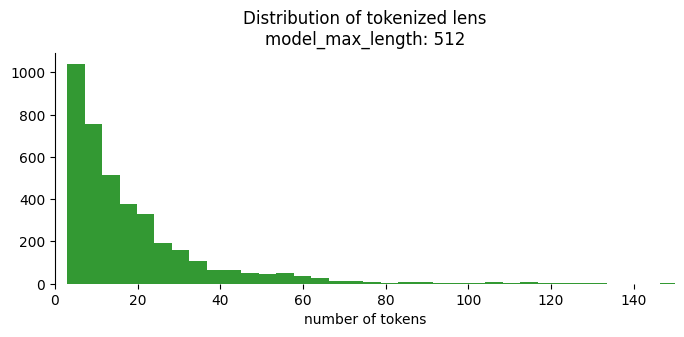

In [6]:
(
    df_trn.answer_clean
    .apply(lambda txt: len(tokenizer(txt)['input_ids']))
    .pipe(
        lambda ser_:
        display(ser_.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])) or ser_
    )
    .hist(bins=200, grid=False, color='green', alpha=0.8)
)
plt.xlim(0, 150)
plt.gcf().set_size_inches(8, 3)
plt.xlabel('number of tokens')
plt.title(f'Distribution of tokenized lens\nmodel_max_length: {tokenizer.model_max_length}')
plt.gca().spines[['bottom', 'right', 'top']].set_visible(False)

In [7]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    'train': Dataset.from_dict(df_trn[['answer_clean']].reset_index(names='index')),
    'val': Dataset.from_dict(df_val[['answer_clean']].reset_index(names='index'))
})
display(dataset)

DatasetDict({
    train: Dataset({
        features: ['index', 'answer_clean'],
        num_rows: 3929
    })
    val: Dataset({
        features: ['index', 'answer_clean'],
        num_rows: 1310
    })
})

### Prepare data for MLM

Tokenize without special tokens

String them together with [SEP] between samples

Chunk into 512, enforcing it starts/ends with [CLS]/[SEP]

Define labels=copy of input tokens

In [8]:
#These will include the last irregular chunk
def concat_and_chunk(dataset, tokenizer):
    chunk_size = tokenizer.model_max_length

    cls_token_id, sep_token_id = [
        tokenizer.convert_tokens_to_ids(tokenizer.special_tokens_map[token])
        for token in ['cls_token', 'sep_token',]
    ]
    pad_token_id = tokenizer.pad_token_type_id

    dataset = dataset.to_dict() #same as dataset[:] ie returns dict (aot Dataset)

    #Mark each end-of-record before stringing the corpus together
    # BERT doesn't have eos_token_id. All BERT seq start with CLS. Will use SEP btw samples. And end for compat.
    
    #tids0 [SEP] tids1 [SEP] ... tidsN [SEP]
    dataset['input_ids'] = [
        ids + [sep_token_id]
        for ids in dataset['input_ids']
    ]
    dataset['attention_mask'] = [
        attn_mask + [1]
        for attn_mask in dataset['attention_mask']
    ]
    
    #Concatenate
    concatenated = {
        k: sum(list_per_sample, []) for k, list_per_sample in dataset.items()
    }

    #Chunk
    # This will include the final irregular chunk
    concat_length = len(concatenated['input_ids'])
    chunked = {
        k: [ v[ix : ix + chunk_size] for ix in range(0, concat_length, chunk_size) ]
        for k, v in concatenated.items()
    }

    #Enforce that first/last token of each 512 input_id chunk are [CLS]/[SEP]
    # each chunk will become->   [CLS]  chunk_i[:-2]  [SEP]
    # extra detail of using [PAD] in cases where [3rd from last] [SEP] would result in [SEP] [SEP]
    chunked['input_ids'] = [
        [cls_token_id] + ids_chunk[:-2] + ([sep_token_id] if ids_chunk[-3] != sep_token_id else [pad_token_id])
        for ids_chunk in chunked['input_ids']
    ]

    #right-pad the tail to chunk_size
    # use pad_token_id for input_ids padding, and 0 for padding attention_mask
    padding_len = chunk_size - len(chunked['input_ids'][-1])

    if padding_len:
        for k in concatenated.keys():
            chunked[k][-1] = chunked[k][-1] + padding_len * [pad_token_id if k=='input_ids' else 0]

    return Dataset.from_dict(chunked)

#Tokenize and retain only input_ids and attention_mask
# Skip special tokens as they'll be handled on concatenation & chunking
tokenized = dataset.map(
    lambda batch: tokenizer(batch['answer_clean'], truncation=False, add_special_tokens=False),
    batched=True,
    remove_columns=['answer_clean', 'index']
)

chunked = DatasetDict({
    'train': concat_and_chunk(tokenized['train'], tokenizer),
    'val': concat_and_chunk(tokenized['val'], tokenizer)
})

#Assign labels
chunked = chunked.map(lambda dataset: {'labels': dataset['input_ids'].copy()})

if 'tinybert' in use_checkpoint.lower():
    chunked = chunked.remove_columns('token_type_ids') #tb adds this, remove

Map:   0%|          | 0/3929 [00:00<?, ? examples/s]

Map:   0%|          | 0/1310 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

### Fine-tuning

Instantiate collator

In [9]:
from transformers import DataCollatorForLanguageModeling

#Lanuage modelling collator
# Expects list of dict [{sample1}, ..., {sampleN}]
mlm_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.15,
    return_tensors='pt'
)

Try collator

In [10]:
samples = [chunked['train'][i] for i in range(2)]
# display(samples)

collated_batch = mlm_collator(samples)

display( collated_batch.keys() )
display( collated_batch['input_ids'].shape )

#What a masked sample looks like:
display(
    tokenizer.decode( collated_batch['input_ids'][0])
)

#What the corresponding labels look like
coll_labels = collated_batch['labels'][0]
coll_labels[coll_labels==-100] = tokenizer.pad_token_type_id
display( tokenizer.decode(coll_labels) )

#NB. It masks tokens (parts of words) and not necessarily an entire word
# tokenizer.convert_ids_to_tokens(collated_batch['input_ids'][0])

dict_keys(['input_ids', 'attention_mask', 'labels'])

torch.Size([2, 512])

'[CLS] made me comfortable and [MASK] ease. [SEP] [MASK] honest. [SEP] absolutely everything. [SEP] nothing. [SEP] [MASK] the ward is too noisy. sometimes my routine changes and i find [MASK] hared to deal with. [SEP] the care staff, the nursing staff and the domestic staff. food, cleanliness 7 [MASK] ( mon - fri ) [MASK] [SEP] kind and very [MASK]fecional made me feel at ease [SEP] compromise, stop constantlyoshi [MASK] [SEP] ambulance staff very good, [MASK], friendly approach [MASK]. [SEP] healed my [MASK] ulcer, helped me get antibiotics. nothing was too much trouble. [SEP] food. [SEP] [MASK]. [SEP] nuffin, things are fine as they are. [SEP] nothing. [SEP] because i cannot use public transport due to disability and because i was asked to [MASK] this survey. [SEP] the [MASK]naire i receive every week can be modified a bit [MASK] [SEP] very helpful [SEP] [MASK] [MASK] could be up to 1 hour 30 mins arrived less than 30 minutes [SEP] nothing, doing everything you can instructions [SEP]

'[PAD] [PAD] [PAD] [PAD] [PAD] at [PAD] [PAD] [PAD] being [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] sometimes [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] it [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] activities [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]. [PAD] [PAD] [PAD] [PAD] prof [PAD] [PAD] [PAD] [PAD] [PAD] feel [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] being. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] reassuring [PAD] [PAD] [PAD]able [PAD] [PAD] [PAD] [PAD] leg [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] nothing [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] and [PAD] [PAD] [PAD] [PAD] [PAD] fill [PAD] [PAD] [PAD] [PAD] [PAD] question [PAD] [PAD] [PAD] every [PAD] [PAD] [PAD] [PA

Training loop

- bs 16
- 80 epochs

In [11]:
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling, get_scheduler, pipeline
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

from shutil import rmtree
from pathlib import Path

tb_dir = 'runs/bs16'
# rmtree(tb_dir)
Path(tb_dir).mkdir(exist_ok=True)
writer = SummaryWriter(tb_dir)

#
# Eval function
#
@torch.no_grad()
def evaluate(model, loader, device):
    """Return mean loss and perplexity for model over loader"""
    model.eval()
    losses = []

    for batch in tqdm(loader, desc='evaluate', unit='minibatch', disable=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        losses.append( model(**batch).loss.item() )
    
    return np.mean(losses), np.exp(np.mean(losses))

#
# Load model and tokenizer
#
model = AutoModelForMaskedLM.from_pretrained(use_checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(use_checkpoint)

#
# Configure optimizer, collator, and data loaders
#
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

mlm_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.15,
    return_tensors='pt'
)

batch_size = 16

train_dataloader = DataLoader(
    chunked['train'],
    shuffle=True,
    batch_size=batch_size,
    pin_memory=True,
    collate_fn=mlm_collator,
)

val_dataloader = DataLoader(
    chunked['val'],
    batch_size=batch_size,
    pin_memory=True,
    collate_fn=mlm_collator,
)

#
# Set up number of epochs and lr scheduler
#
num_train_epochs = 80
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
print('Steps per epoch:', num_update_steps_per_epoch)
print('Total training steps:', num_training_steps)

lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)

#
#Assess performance before domain adaptation
#
top_k = 8
text = 'the [MASK] took a while'
# text = 'i rang [MASK]'
# text = 'i had to wait for the [MASK] to arrive'

loss, perplexity = evaluate(model, val_dataloader, device)
print(f'baseline {use_checkpoint}'.center(85, '`'))
print('base model: loss %.3f | perplexity %.1f' % (loss, perplexity), end='\n\n')

print(text)
preds = pipeline('fill-mask', model, tokenizer=tokenizer, top_k=top_k)(text)
pd.DataFrame([[pred['token_str'] for pred in preds]], index=['base']).rename_axis(columns='top k').pipe(display)

#
# Training loop
#
preds_perepoch = []
progress_bar = tqdm(range(num_training_steps), desc='training steps', unit='minibatch')

for epoch in range(num_train_epochs):
    
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update()
    #/end of epoch

    #
    # Evaluate per epoch
    #
    model.eval()
    trn_loss, trn_perp = evaluate(model, train_dataloader, device)
    val_loss, val_perp = evaluate(model, val_dataloader, device)

    #Print results
    print(
        f'[epoch {epoch + 1:2d}/{num_train_epochs:2d}]',
        f'[TRN loss: {trn_loss:5.3f} | perp {trn_perp:5.1f}]',
        f'[VAL loss: {val_loss:5.3f} | perp {val_perp:5.1f}]',
    )

    #Record top k examples
    preds = pipeline('fill-mask', model, tokenizer=tokenizer, top_k=14)(text)
    preds_perepoch.append([pred['token_str'] for pred in preds])

    #Write to tensorboard
    writer.add_scalars('loss', {'trn': trn_loss, 'val': val_loss}, global_step=epoch + 1)
    writer.add_scalars('perp', {'trn': trn_perp, 'val': val_perp}, global_step=epoch + 1)
    writer.add_text('mask filling', '\n'.join(preds_perepoch[-1]), global_step=epoch + 1)

pd.DataFrame(preds_perepoch, index=np.arange(1, num_train_epochs + 1)).rename_axis(index='epoch', columns='top k').style

Steps per epoch: 9
Total training steps: 720


Device set to use cuda:0


`````````````````````baseline distilbert/distilbert-base-uncased`````````````````````
base model: loss 3.882 | perplexity 48.5

the [MASK] took a while


top k,0,1,2,3,4,5,6,7
base,movie,story,film,conversation,project,painting,game,filming


training steps:   0%|          | 0/720 [00:00<?, ?minibatch/s]

Device set to use cuda:0


[epoch  1/80] [TRN loss: 3.646 | perp  38.3] [VAL loss: 3.779 | perp  43.8]


Device set to use cuda:0


[epoch  2/80] [TRN loss: 3.262 | perp  26.1] [VAL loss: 3.149 | perp  23.3]


Device set to use cuda:0


[epoch  3/80] [TRN loss: 3.021 | perp  20.5] [VAL loss: 2.620 | perp  13.7]


Device set to use cuda:0


[epoch  4/80] [TRN loss: 2.934 | perp  18.8] [VAL loss: 3.008 | perp  20.2]


Device set to use cuda:0


[epoch  5/80] [TRN loss: 2.864 | perp  17.5] [VAL loss: 2.541 | perp  12.7]


Device set to use cuda:0


[epoch  6/80] [TRN loss: 2.778 | perp  16.1] [VAL loss: 2.625 | perp  13.8]


Device set to use cuda:0


[epoch  7/80] [TRN loss: 2.675 | perp  14.5] [VAL loss: 2.673 | perp  14.5]


Device set to use cuda:0


[epoch  8/80] [TRN loss: 2.600 | perp  13.5] [VAL loss: 2.894 | perp  18.1]


Device set to use cuda:0


[epoch  9/80] [TRN loss: 2.626 | perp  13.8] [VAL loss: 2.775 | perp  16.0]


Device set to use cuda:0


[epoch 10/80] [TRN loss: 2.549 | perp  12.8] [VAL loss: 2.396 | perp  11.0]


Device set to use cuda:0


[epoch 11/80] [TRN loss: 2.461 | perp  11.7] [VAL loss: 2.533 | perp  12.6]


Device set to use cuda:0


[epoch 12/80] [TRN loss: 2.426 | perp  11.3] [VAL loss: 2.683 | perp  14.6]


Device set to use cuda:0


[epoch 13/80] [TRN loss: 2.349 | perp  10.5] [VAL loss: 2.474 | perp  11.9]


Device set to use cuda:0


[epoch 14/80] [TRN loss: 2.370 | perp  10.7] [VAL loss: 2.403 | perp  11.1]


Device set to use cuda:0


[epoch 15/80] [TRN loss: 2.319 | perp  10.2] [VAL loss: 2.308 | perp  10.1]


Device set to use cuda:0


[epoch 16/80] [TRN loss: 2.320 | perp  10.2] [VAL loss: 2.859 | perp  17.4]


Device set to use cuda:0


[epoch 17/80] [TRN loss: 2.241 | perp   9.4] [VAL loss: 2.603 | perp  13.5]


Device set to use cuda:0


[epoch 18/80] [TRN loss: 2.260 | perp   9.6] [VAL loss: 2.567 | perp  13.0]


Device set to use cuda:0


[epoch 19/80] [TRN loss: 2.187 | perp   8.9] [VAL loss: 2.314 | perp  10.1]


Device set to use cuda:0


[epoch 20/80] [TRN loss: 2.144 | perp   8.5] [VAL loss: 2.559 | perp  12.9]


Device set to use cuda:0


[epoch 21/80] [TRN loss: 2.140 | perp   8.5] [VAL loss: 2.677 | perp  14.5]


Device set to use cuda:0


[epoch 22/80] [TRN loss: 2.109 | perp   8.2] [VAL loss: 2.555 | perp  12.9]


Device set to use cuda:0


[epoch 23/80] [TRN loss: 2.114 | perp   8.3] [VAL loss: 2.465 | perp  11.8]


Device set to use cuda:0


[epoch 24/80] [TRN loss: 2.080 | perp   8.0] [VAL loss: 2.778 | perp  16.1]


Device set to use cuda:0


[epoch 25/80] [TRN loss: 2.022 | perp   7.5] [VAL loss: 2.598 | perp  13.4]


Device set to use cuda:0


[epoch 26/80] [TRN loss: 2.020 | perp   7.5] [VAL loss: 2.689 | perp  14.7]


Device set to use cuda:0


[epoch 27/80] [TRN loss: 2.034 | perp   7.6] [VAL loss: 2.628 | perp  13.8]


Device set to use cuda:0


[epoch 28/80] [TRN loss: 1.974 | perp   7.2] [VAL loss: 2.497 | perp  12.2]


Device set to use cuda:0


[epoch 29/80] [TRN loss: 1.962 | perp   7.1] [VAL loss: 2.571 | perp  13.1]


Device set to use cuda:0


[epoch 30/80] [TRN loss: 1.958 | perp   7.1] [VAL loss: 2.189 | perp   8.9]


Device set to use cuda:0


[epoch 31/80] [TRN loss: 1.897 | perp   6.7] [VAL loss: 2.575 | perp  13.1]


Device set to use cuda:0


[epoch 32/80] [TRN loss: 1.927 | perp   6.9] [VAL loss: 2.854 | perp  17.4]


Device set to use cuda:0


[epoch 33/80] [TRN loss: 1.903 | perp   6.7] [VAL loss: 2.179 | perp   8.8]


Device set to use cuda:0


[epoch 34/80] [TRN loss: 1.868 | perp   6.5] [VAL loss: 2.363 | perp  10.6]


Device set to use cuda:0


[epoch 35/80] [TRN loss: 1.879 | perp   6.5] [VAL loss: 2.442 | perp  11.5]


Device set to use cuda:0


[epoch 36/80] [TRN loss: 1.820 | perp   6.2] [VAL loss: 2.426 | perp  11.3]


Device set to use cuda:0


[epoch 37/80] [TRN loss: 1.814 | perp   6.1] [VAL loss: 2.696 | perp  14.8]


Device set to use cuda:0


[epoch 38/80] [TRN loss: 1.837 | perp   6.3] [VAL loss: 2.619 | perp  13.7]


Device set to use cuda:0


[epoch 39/80] [TRN loss: 1.797 | perp   6.0] [VAL loss: 2.395 | perp  11.0]


Device set to use cuda:0


[epoch 40/80] [TRN loss: 1.802 | perp   6.1] [VAL loss: 2.513 | perp  12.3]


Device set to use cuda:0


[epoch 41/80] [TRN loss: 1.748 | perp   5.7] [VAL loss: 2.393 | perp  10.9]


Device set to use cuda:0


[epoch 42/80] [TRN loss: 1.785 | perp   6.0] [VAL loss: 2.578 | perp  13.2]


Device set to use cuda:0


[epoch 43/80] [TRN loss: 1.736 | perp   5.7] [VAL loss: 2.182 | perp   8.9]


Device set to use cuda:0


[epoch 44/80] [TRN loss: 1.743 | perp   5.7] [VAL loss: 2.484 | perp  12.0]


Device set to use cuda:0


[epoch 45/80] [TRN loss: 1.722 | perp   5.6] [VAL loss: 2.866 | perp  17.6]


Device set to use cuda:0


[epoch 46/80] [TRN loss: 1.738 | perp   5.7] [VAL loss: 2.371 | perp  10.7]


Device set to use cuda:0


[epoch 47/80] [TRN loss: 1.684 | perp   5.4] [VAL loss: 2.259 | perp   9.6]


Device set to use cuda:0


[epoch 48/80] [TRN loss: 1.688 | perp   5.4] [VAL loss: 2.041 | perp   7.7]


Device set to use cuda:0


[epoch 49/80] [TRN loss: 1.687 | perp   5.4] [VAL loss: 2.452 | perp  11.6]


Device set to use cuda:0


[epoch 50/80] [TRN loss: 1.640 | perp   5.2] [VAL loss: 2.074 | perp   8.0]


Device set to use cuda:0


[epoch 51/80] [TRN loss: 1.659 | perp   5.3] [VAL loss: 2.453 | perp  11.6]


Device set to use cuda:0


[epoch 52/80] [TRN loss: 1.649 | perp   5.2] [VAL loss: 2.885 | perp  17.9]


Device set to use cuda:0


[epoch 53/80] [TRN loss: 1.596 | perp   4.9] [VAL loss: 2.560 | perp  12.9]


Device set to use cuda:0


[epoch 54/80] [TRN loss: 1.642 | perp   5.2] [VAL loss: 2.499 | perp  12.2]


Device set to use cuda:0


[epoch 55/80] [TRN loss: 1.601 | perp   5.0] [VAL loss: 2.765 | perp  15.9]


Device set to use cuda:0


[epoch 56/80] [TRN loss: 1.618 | perp   5.0] [VAL loss: 2.155 | perp   8.6]


Device set to use cuda:0


[epoch 57/80] [TRN loss: 1.640 | perp   5.2] [VAL loss: 2.120 | perp   8.3]


Device set to use cuda:0


[epoch 58/80] [TRN loss: 1.598 | perp   4.9] [VAL loss: 2.647 | perp  14.1]


Device set to use cuda:0


[epoch 59/80] [TRN loss: 1.613 | perp   5.0] [VAL loss: 2.251 | perp   9.5]


Device set to use cuda:0


[epoch 60/80] [TRN loss: 1.591 | perp   4.9] [VAL loss: 2.153 | perp   8.6]


Device set to use cuda:0


[epoch 61/80] [TRN loss: 1.576 | perp   4.8] [VAL loss: 2.135 | perp   8.5]


Device set to use cuda:0


[epoch 62/80] [TRN loss: 1.573 | perp   4.8] [VAL loss: 2.422 | perp  11.3]


Device set to use cuda:0


[epoch 63/80] [TRN loss: 1.536 | perp   4.6] [VAL loss: 1.988 | perp   7.3]


Device set to use cuda:0


[epoch 64/80] [TRN loss: 1.521 | perp   4.6] [VAL loss: 2.145 | perp   8.5]


Device set to use cuda:0


[epoch 65/80] [TRN loss: 1.550 | perp   4.7] [VAL loss: 2.719 | perp  15.2]


Device set to use cuda:0


[epoch 66/80] [TRN loss: 1.542 | perp   4.7] [VAL loss: 2.432 | perp  11.4]


Device set to use cuda:0


[epoch 67/80] [TRN loss: 1.529 | perp   4.6] [VAL loss: 2.669 | perp  14.4]


Device set to use cuda:0


[epoch 68/80] [TRN loss: 1.535 | perp   4.6] [VAL loss: 2.510 | perp  12.3]


Device set to use cuda:0


[epoch 69/80] [TRN loss: 1.512 | perp   4.5] [VAL loss: 2.253 | perp   9.5]


Device set to use cuda:0


[epoch 70/80] [TRN loss: 1.542 | perp   4.7] [VAL loss: 2.456 | perp  11.7]


Device set to use cuda:0


[epoch 71/80] [TRN loss: 1.501 | perp   4.5] [VAL loss: 2.334 | perp  10.3]


Device set to use cuda:0


[epoch 72/80] [TRN loss: 1.545 | perp   4.7] [VAL loss: 2.676 | perp  14.5]


Device set to use cuda:0


[epoch 73/80] [TRN loss: 1.488 | perp   4.4] [VAL loss: 2.525 | perp  12.5]


Device set to use cuda:0


[epoch 74/80] [TRN loss: 1.481 | perp   4.4] [VAL loss: 2.202 | perp   9.0]


Device set to use cuda:0


[epoch 75/80] [TRN loss: 1.495 | perp   4.5] [VAL loss: 1.953 | perp   7.1]


Device set to use cuda:0


[epoch 76/80] [TRN loss: 1.515 | perp   4.6] [VAL loss: 2.158 | perp   8.7]


Device set to use cuda:0


[epoch 77/80] [TRN loss: 1.546 | perp   4.7] [VAL loss: 2.269 | perp   9.7]


Device set to use cuda:0


[epoch 78/80] [TRN loss: 1.517 | perp   4.6] [VAL loss: 2.426 | perp  11.3]


Device set to use cuda:0


[epoch 79/80] [TRN loss: 1.537 | perp   4.6] [VAL loss: 2.553 | perp  12.8]


Device set to use cuda:0


[epoch 80/80] [TRN loss: 1.505 | perp   4.5] [VAL loss: 3.019 | perp  20.5]


top k,0,1,2,3,4,5,6,7,8,9,10,11,12,13
epoch,,,,,,,,,,,,,,
1,movie,story,film,project,conversation,game,painting,song,filming,meeting,trip,show,ride,search
2,movie,story,film,project,song,show,game,meeting,conversation,filming,ride,trip,play,painting
3,story,movie,film,project,song,show,game,filming,meeting,play,ride,conversation,search,trip
4,story,movie,film,conversation,song,project,show,search,game,play,book,filming,ride,trial
5,movie,story,film,show,song,project,conversation,search,journey,ride,incident,play,filming,book
6,movie,story,film,show,project,search,ride,journey,song,play,conversation,filming,investigation,video
7,movie,story,film,project,ride,show,journey,song,search,play,conversation,investigation,tour,time
8,story,movie,project,search,journey,song,ride,film,show,play,investigation,time,conversation,appointment
9,story,journey,ride,movie,appointment,search,song,project,investigation,play,conversation,show,trip,film


In [12]:
from model_utils import save_embedding_weights

# save_embedding_weights(model.distilbert.embeddings, 'domain_adapted-' + use_checkpoint)